In [26]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
# import importlib
# importlib.reload(Energy.Models)

In [27]:
df = get_dax_data()

In [28]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [29]:
df_cval.tail()

,Close,ret1,ret2,ret3,ret4,ret5
2023-12-18,16650.550781,-0.604090,-0.608812,-0.691276,-0.844382,-0.860397
2023-12-19,16744.410156,0.562118,-0.041971,-0.046693,-0.129157,-0.282263
2023-12-20,16733.050781,-0.067863,0.494256,-0.109834,-0.114556,-0.197020
2023-12-21,16687.419922,-0.273071,-0.340934,0.221184,-0.382905,-0.387627
2023-12-22,16706.179688,0.112355,-0.160716,-0.228579,0.333540,-0.270550


In [30]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        
        pred = None
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else: 
            pred = mix_models(model['function'][0], model['function'][1], df_before, target='DAX')
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [[horizon+1, d] for horizon,d in enumerate(pred['forecast_date']) if d in df.index]
        pred = pred.set_index('forecast_date')

        
        # Add observations to pred
        pred['observation'] = ''
        pred['score'] = ''
        for h,d in dates:
            # Look up the right observation for date d
            o = df.loc[d][f'ret{h}']
            pred.loc[d,'observation'] = o
    
        # Add scores to pred
        for index, row in pred.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['observation']
            
            score = evaluate_horizon(quantile_preds, observation)
            
            pred.at[index, 'score'] = score
            
        evaluation = pd.concat([evaluation, pred])
    evaluation = evaluation.sort_index()
    
    return evaluation

In [33]:
from DAX.Models import arma_garch_11 as ag
import importlib
importlib.reload(ag)

models = [
    {
        'name': 'garch11_norm_1y',
        'function': ag.garch11_norm_1y
    },
    {
        'name': 'garch11_norm_2y',
        'function': ag.garch11_norm_2y
    },
    {
        'name': 'garch11_norm_5y',
        'function': ag.garch11_norm_5y
    },
]


In [ ]:
evaluate_models(models, df, 50, weeks=True)

*********** Start the evaluation of Model garch11_norm_1y ***********
Iteration 1 of 50
Iteration 2 of 50
Iteration 3 of 50
Iteration 4 of 50
Iteration 5 of 50
Iteration 6 of 50
Iteration 7 of 50
Iteration 8 of 50
Iteration 9 of 50
Iteration 10 of 50
Iteration 11 of 50
Iteration 12 of 50
Iteration 13 of 50
Iteration 14 of 50
Iteration 15 of 50
Iteration 16 of 50
Iteration 17 of 50
Iteration 18 of 50
Iteration 19 of 50
Iteration 20 of 50
Iteration 21 of 50
Iteration 22 of 50


In [ ]:
# with open('./Model evaluations/ARMAGARCH11.pkl', 'wb') as f:
#     pickle.dump(models, f)
#         
# with open('./Model evaluations/baseline.pkl', 'rb') as f:
#     models = pickle.load(f)

In [8]:
horizons = [str(i) + " day" for i in (1, 2, 5, 6, 7)]
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)
score_df = score_df.sort_index()

In [9]:
score_df

,arma_garch_11_8df: 1 day,arma_garch_11_3df: 1 day,arma_garch_11_norm: 1 day,garch_11_8df: 1 day,garch_11_norm: 1 day,arma_garch_11_8df: 2 day,arma_garch_11_3df: 2 day,arma_garch_11_norm: 2 day,garch_11_8df: 2 day,garch_11_norm: 2 day,...,arma_garch_11_8df: 6 day,arma_garch_11_3df: 6 day,arma_garch_11_norm: 6 day,garch_11_8df: 6 day,garch_11_norm: 6 day,arma_garch_11_8df: 7 day,arma_garch_11_3df: 7 day,arma_garch_11_norm: 7 day,garch_11_8df: 7 day,garch_11_norm: 7 day
forecast_date,,,,,,,,,,,,,,,,,,,,,
2023-01-13,1.180701,1.950372,1.21948,1.206797,1.266519,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-16,NaN,NaN,NaN,NaN,NaN,1.388814,2.165122,1.421951,2.430822,2.186706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.746295,2.894885,1.61314,4.202699,3.438969,NaN,NaN,NaN,NaN,NaN
2023-01-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.31331,4.986131,5.716301,6.160231,4.628023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,None,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,None,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-27,None,None,None,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Plot obtained scores

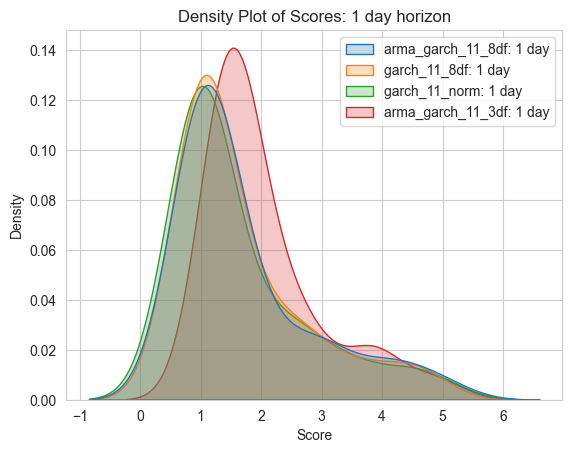

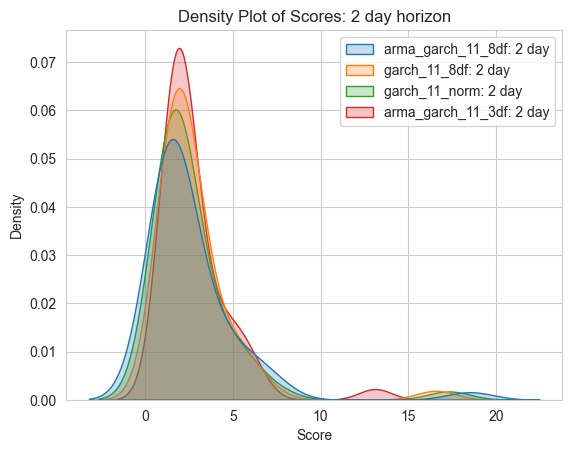

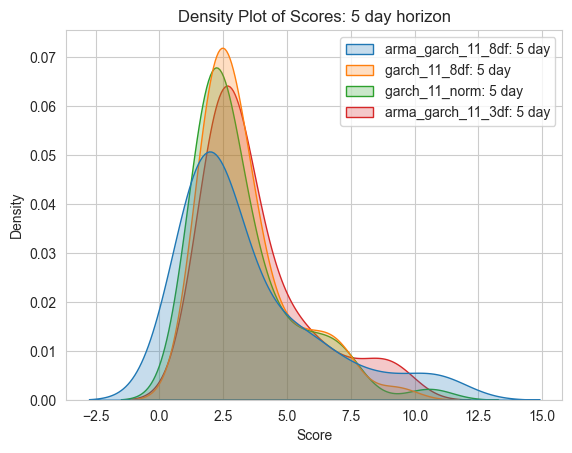

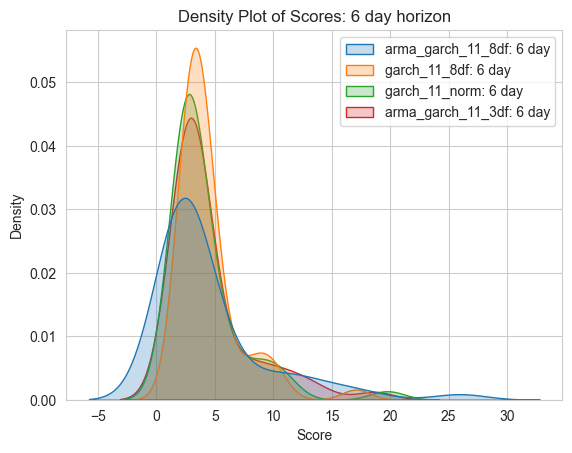

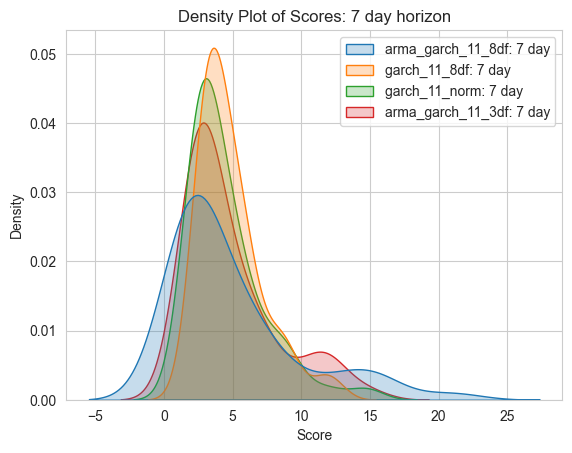

In [22]:
# models_display = ['baseline','garch11_t', 'arma_garch_11', 'baseline_armagarch11']
models_display = ['arma_garch_11_8df', 'garch_11_8df', 'garch_11_norm','arma_garch_11_3df']
# models_display = ['baseline', 'model4_sunhours', 'model4_holidays_2', 'model4', 'model4_population']
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    # sns.kdeplot(data=score_df.loc[:,[f'baseline: {h}',f'model3: {h}',f'MM_baseline_model3: {h}']], fill=True)
    sns.kdeplot(data=score_df.loc[:,[f'{m}: {h}' for m in models_display]], fill=True)
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')
    
    # Display the plot
    plt.savefig(f'../Plots/density_plot_{h.replace(" ", "_")}.png')
    plt.show()

In [24]:
import statistics
horizon = '1 day'
score_df.loc[:,[f'{m}: {h}' for m in models_display]]
for i,m in enumerate([statistics.mean(score_df.loc[:,f'{m}: {horizon}'].dropna()) for m in models_display]):
    print(f'{models_display[i]} mean score in the past 50 weeks: {m}')

arma_garch_11_8df mean score in the past 50 weeks: 1.7227542688359776
garch_11_8df mean score in the past 50 weeks: 1.6881957496589421
garch_11_norm mean score in the past 50 weeks: 1.6436973347770418
arma_garch_11_3df mean score in the past 50 weeks: 2.03179696665573


In [ ]:
for h in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    score_df_36_no_na = score_df[score_df[f'{models_display[0]}: {h}'].notna()]
    for c in [f'{m}: {h}' for m in models_display]:
        plt.plot(score_df_36_no_na.index, score_df_36_no_na[c], label=c)

    plt.xlabel('time')
    plt.ylabel('score')
    plt.title(f'Comparison of scores over time: {h}')
    # plt.ylim(0,50)
    
    # Display legend
    plt.legend()
    plt.xticks(rotation=45)
    plt.savefig(f'../Plots/line_plot_{h.replace(" ", "_")}.png')

    # Show the plot
    plt.show()

In [33]:


import matplotlib.pyplot as plt

def plot_evaluation(evaluation_data):
    # Assuming your DataFrame is named df
    numeric_columns = evaluation_data.select_dtypes(include='number')
    
    # Plotting
    plt.figure(figsize=(12, 8))
    for column in numeric_columns.columns:
        plt.plot(evaluation_data.index, evaluation_data[column], label=column)
    plt.plot(evaluation_data.index, evaluation_data['observation'], label = 'observation')
    
    # Adding labels and legend
    plt.xlabel('Forecast Date')
    plt.ylabel('Values')
    plt.title('Visualization of forecast and observation')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig(f'../plots/evaluation_overview.png')
    plt.show()



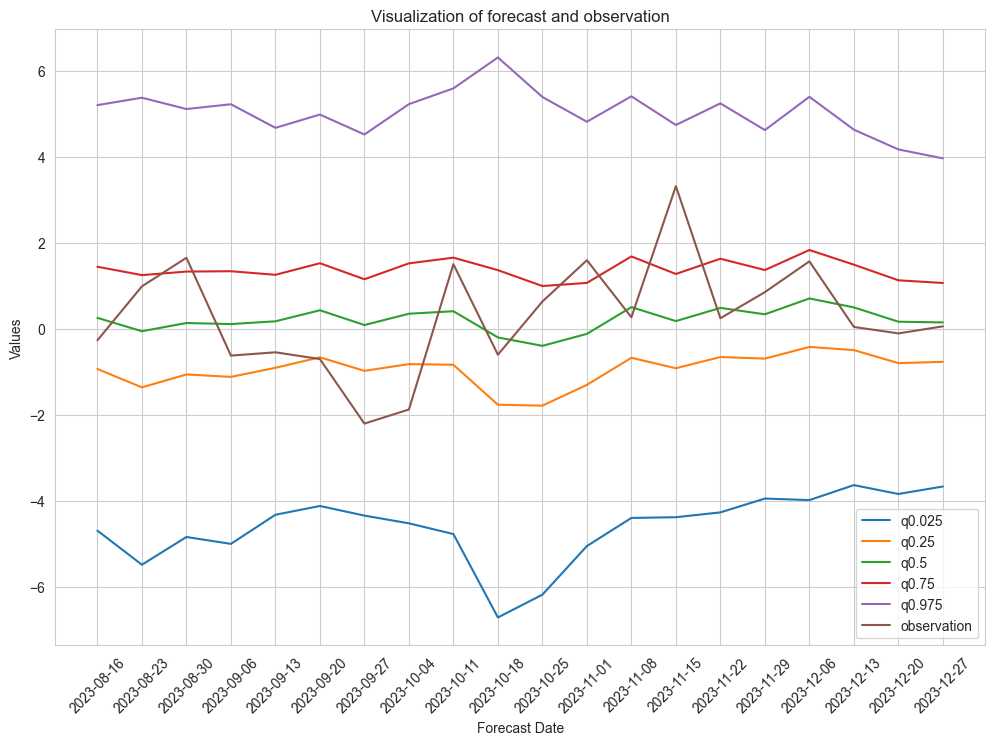

In [34]:
model_index = 1
plot_evaluation(models[model_index]['evaluation'][models[model_index]['evaluation']['horizon'] == '5 day'].dropna())

In [ ]:
models[0]['evaluation']